In [ ]:
import time
from tqdm import tqdm 

import numpy as np
import pandas as pd
import h5py

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from keras import backend as K
import tensorflow.keras as ks

from keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, Add, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2

SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

from utilities import *

# Part 1: CNN for classifying the MNIST dataset

## Loading MNIST

In [ ]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets, X_val, y_val # Good to reduce uneccesary RAM usage

11490434/11490434 [==============================] - 0s 0us/step


## Preprocessing

In [ ]:
# Reshape data to account for color channel
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Normalizing input between [0,1]
X_train = X_train.astype("float32")/np.max(X_train)
X_test  = X_test.astype("float32")/np.max(X_test)

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test  = ks.utils.to_categorical(y_test, len(np.unique(y_test)))

In [ ]:
print('Training:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape )

Training: (60000, 28, 28, 1) (60000, 10)
Test Set: (10000, 28, 28, 1) (10000, 10)


In [ ]:
# Check that our training values have been normalized
print("Min value in X_train:", X_train.min())
print("Max value in X_train:", X_train.max())
print('Unique values in X_train:\n', np.unique(X_train))

Min value in X_train: 0.0
Max value in X_train: 1.0
Unique values in X_train:
 [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156

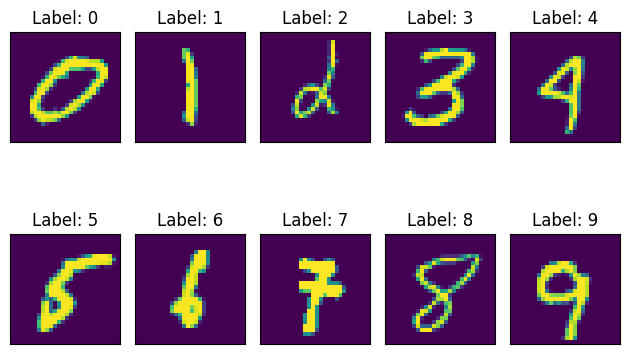

In [ ]:
# Visualize each label
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

# Iterate through each class (from 0 to 9)
for i in range(10):
    # Find the first sample where the encoded label has a '1' at the i-th position
    img = X_train[np.argmax(y_train, axis=1) == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='viridis')
    ax[i].set_title(f"Label: {i}")

# Remove x and y ticks for all subplots
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# F1-score implementation with K from keras
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val


In [ ]:
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=1/6, random_state=SEED)

## Task 1.1: Build a network with the LeNet CNN architecture

### Task 1.1.1 Building network

Implement the famous LeNet architecture according to the following specifications:

--------------------------
The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU.

**MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU.

**MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.

--------------------------

Compile the network with the
* `MSE` loss function
* the `adam` optimizer
* with the `accuracy` metric and (your own implementation of the) F1-score metric.

In [ ]:
# Defining the LeNet CNN architecture
def leNet_model():
    model = Sequential()

    model.add(Conv2D(6, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model


model = leNet_model()



# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score])


### Task 1.1.2 Train network

Train the network with a
* batch size of 128 samples
* for 40 epochs
* 1/6 validation split

In [ ]:
# Training our model
history = model.fit(X_train_split, y_train_split,
                    batch_size = 128,
                    epochs = 40,
                    validation_data = (X_val_split, y_val_split))

Epoch 1/40
391/391 [==============================] - 14s 7ms/step - loss: 1.0841 - accuracy: 0.6963 - f1_score: 0.5045 - val_loss: 0.4025 - val_accuracy: 0.8862 - val_f1_score: 0.8798
Epoch 2/40
391/391 [==============================] - 2s 6ms/step - loss: 0.3118 - accuracy: 0.9111 - f1_score: 0.9098 - val_loss: 0.2658 - val_accuracy: 0.9207 - val_f1_score: 0.9206
Epoch 3/40
391/391 [==============================] - 2s 6ms/step - loss: 0.2249 - accuracy: 0.9338 - f1_score: 0.9344 - val_loss: 0.2061 - val_accuracy: 0.9387 - val_f1_score: 0.9390
Epoch 4/40
391/391 [==============================] - 2s 5ms/step - loss: 0.1793 - accuracy: 0.9472 - f1_score: 0.9477 - val_loss: 0.1695 - val_accuracy: 0.9489 - val_f1_score: 0.9501
Epoch 5/40
391/391 [==============================] - 2s 5ms/step - loss: 0.1491 - accuracy: 0.9564 - f1_score: 0.9565 - val_loss: 0.1462 - val_accuracy: 0.9561 - val_f1_score: 0.9565
Epoch 6/40
391/391 [==============================] - 2s 5ms/step - loss: 0.129

### Task 1.1.3 Plot training history and evaluate on test dataset

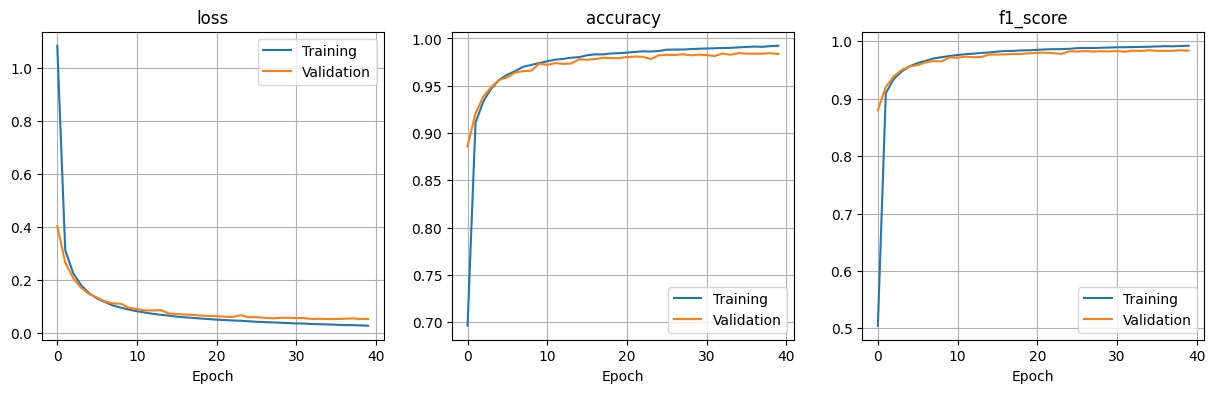

In [ ]:
plot_training_history(history)

### Task 1.1.4 Evaluate on the test dataset

In [ ]:
# Evalute our model on the test data
results = model.evaluate(X_test, y_test)

print(f"Test Loss: {results[0]:.4f} ")
print(f"Test Accuracy: {results[1]:.4f} ")
print(f"Test F1 Score: {results[2]:.4f} ")


313/313 [==============================] - 1s 3ms/step - loss: 0.0366 - accuracy: 0.9885 - f1_score: 0.9884
Test Loss: 0.0366 
Test Accuracy: 0.9885 
Test F1 Score: 0.9884 


# Task 2: CNN for classifying the CIFAR-10 dataset

In this task you shall implement a CNN model, and train it to classify the images in the CIFAR-10 dataset.

## Importing CIFAR-10

Make sure file `student_dataset_CIFAR10.h5` is in the same directory as this notebook. Or you can edit the path from where it is read from.

In [ ]:
dataset_path = './student_dataset_CIFAR10.h5'

with h5py.File(dataset_path,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X_train'])
    y_train = np.asarray(f['y_train'])
    X_test  = np.asarray(f['X_test'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Datasets in file: ['X_test', 'X_train', 'y_train']
Nr. train images: 50000
Nr. test images: 10000


## Task 2.1: Preprocess the data

Preprocess the data as you see fit

In [ ]:
# Normalizing input between [0,1]
X_train = X_train.astype("float32")/np.max(X_train)
X_test  = X_test.astype("float32")/np.max(X_test)


# One hot encoding
y_train_encoded = to_categorical(y_train, num_classes = 10)



## Task 2.2: Visualize the dataset

Plot a few samples images and masks. Feel free to visualize any other aspects of the dataset that you feel are relevant.

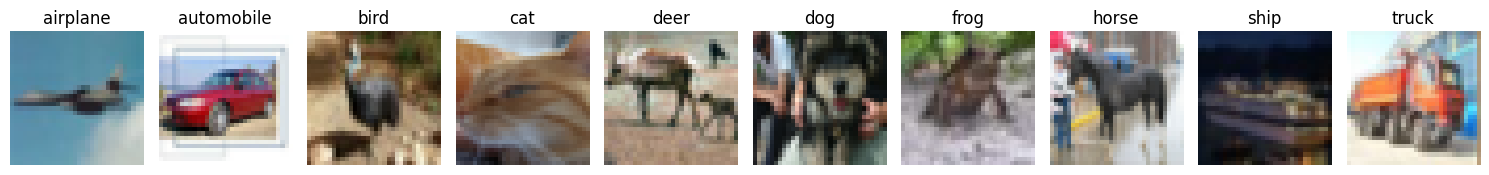

In [ ]:
# Visualization for each label
def plot_sample_per_label(images, labels, label_names):
    # Assuming labels is a 1D array with class indices
    unique_labels = np.unique(labels)

    plt.figure(figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        # Find the index of the first occurrence of this label
        idx = np.where(labels == label)[0][0]

        plt.subplot(1, len(unique_labels), i+1)
        plt.imshow(images[idx])
        plt.title(label_names[label])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_per_label(X_train, y_train, label_names)

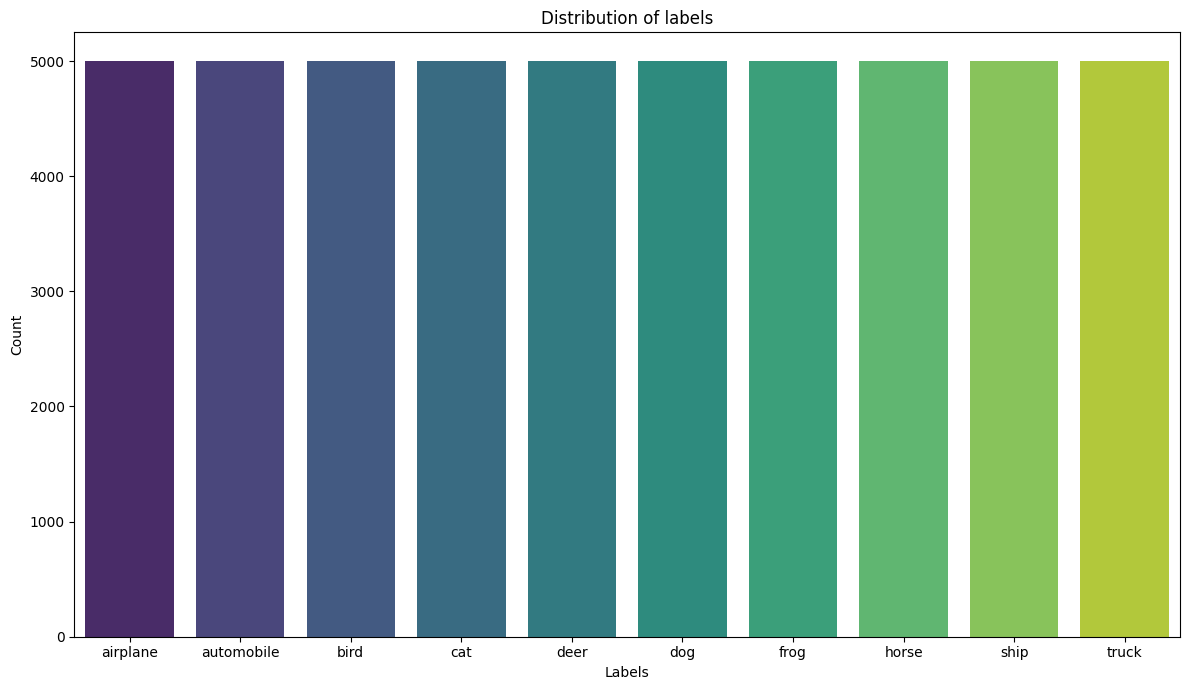

In [ ]:
# Visalization of the distribution
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(12, 7))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.title('Distribution of labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(ticks=range(len(unique)), labels=label_names)
plt.tight_layout()
plt.show()


In [ ]:
# F1-score implementation with K from keras
def custom_f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision*recall) / (precision+recall+K.epsilon())

    return f1_val


In [ ]:
from keras.utils import get_custom_objects

get_custom_objects().update({"custom_f1_score": custom_f1_score})

In [ ]:
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded, test_size=1/6, random_state=SEED)

## Task 2.3: Build a CNN for classifying the CIFAR-10 dataset

Feel free to take inspiration from one of the famous architectures such as LeNet. If you do, please describe where you take inspiration from and give short descriptions on your choice of architecture.

In [ ]:
from tensorflow.keras.regularizers import l2


# Defining our architecture, Inspiration from VGG
def cifar10_model():
    model = Sequential()

    # Convolutional Layers
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(512, (3,3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3,3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))


    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1024, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(10, activation='softmax'))

    return model


model = cifar10_model()


opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'custom_f1_score'])




In [ ]:
# Saving our best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')


# Stop when not improving accuracy
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience=10, verbose=1, restore_best_weights=True)


# Train the model
history = model.fit(X_train_split, y_train_split,
                    epochs=40,
                    batch_size = 32,
                    validation_data=(X_val_split, y_val_split),
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)


Epoch 1/40
1303/1303 [==============================] - ETA: 0s - loss: 2.7715 - accuracy: 0.3737 - custom_f1_score: 0.2851

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1303/1303 [==============================] - 46s 22ms/step - loss: 2.7715 - accuracy: 0.3737 - custom_f1_score: 0.2851 - val_loss: 1.8667 - val_accuracy: 0.5294 - val_custom_f1_score: 0.5027
Epoch 2/40
1303/1303 [==============================] - 27s 21ms/step - loss: 1.6982 - accuracy: 0.5657 - custom_f1_score: 0.5323 - val_loss: 2.0693 - val_accuracy: 0.5205 - val_custom_f1_score: 0.4813
Epoch 3/40
1303/1303 [==============================] - 27s 21ms/step - loss: 1.4838 - accuracy: 0.6395 - custom_f1_score: 0.6200 - val_loss: 1.4264 - val_accuracy: 0.6514 - val_custom_f1_score: 0.6514
Epoch 4/40
1303/1303 [==============================] - 28s 21ms/step - loss: 1.3577 - accuracy: 0.6864 - custom_f1_score: 0.6752 - val_loss: 1.2529 - val_accuracy: 0.7235 - val_custom_f1_score: 0.7170
Epoch 5/40
1303/1303 [==============================] - 28s 21ms/step - loss: 1.2896 - accuracy: 0.7187 - custom_f1_score: 0.7081 - val_loss: 1.2841 - val_accuracy: 0.7291 - val_custom_f1_score: 0.7291
E

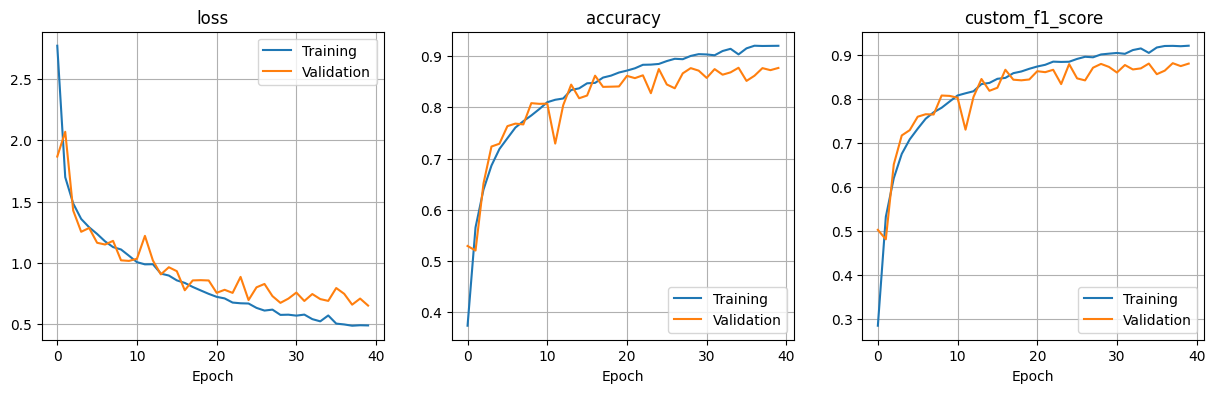

In [ ]:
plot_training_history(history)

## Task 2.4: Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard

In [ ]:
from keras.models import load_model

best_model = load_model('best_model.h5', custom_objects={'custom_f1_score': custom_f1_score})

loss, accuracy, f1_score_val = best_model.evaluate(X_val_split, y_val_split)

print(f"Validation loss: {loss:.4f} ")
print(f"Validation accuracy: {accuracy:.4f} ")
print(f"Validation f1 score: {f1_score_val:.4f} ")

# Prediction with our best model
prediction = best_model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.

261/261 [==============================] - 2s 6ms/step - loss: 0.6889 - accuracy: 0.8774 - custom_f1_score: 0.8802
Validation loss: 0.6889 
Validation accuracy: 0.8774 
Validation f1 score: 0.8802 
313/313 [==============================] - 2s 6ms/step
